# 0️⃣ Prerequisite

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (4,324 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

⚠️⚠️⚠️⚠️⚠️ [런타임] - [런타임 다시 시작] ⚠️⚠️⚠️⚠️⚠️

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj2')

## Import libraries

In [ ]:
!pip install datasets
!pip install levenshtein
!pip install torchinfo
!pip install transformers
!pip install wandb

In [4]:
# Log in to your W&B account
import wandb
wandb.login(key='eeef6909a6674c953c756358e614461bdced83c4')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yangdk02. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
import csv
import json
import math
import numpy as np
import pandas as pd
import pickle
import random
import warnings

from collections import defaultdict, OrderedDict
from datasets import Dataset, load_metric
from easydict import EasyDict as edict
from Levenshtein import distance
from pathlib import Path
from tqdm.auto import tqdm

import torch
from torchinfo import summary

from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    default_data_collator,
    EarlyStoppingCallback,
    get_cosine_schedule_with_warmup,
    PreTrainedTokenizerFast,
    Trainer,
    TrainingArguments
)

import matplotlib.pyplot as plt

In [6]:
args = edict({
       'lr': 1e-5,
       'batch_size': {
            'train': 512,
            'dev': 512,
            'test': 512
        },
        'seed': 42,
        'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        'doc_stride': 200, # The authorized overlap between two part of the context when splitting it is needed.
        'epochs': 30,
        'max_length': 1024, # The maximum length of a feature (question and context)
        'model_checkpoint': 'monologg/kobigbird-bert-base',
        'n_best_size': 10,
        'max_answer_length': 10
})
args['accumulation'] = int(args.batch_size.train/16)
args['model_name'] = args.model_checkpoint.split("/")[-1]
args['name'] = f'{args.model_name}_lr{args.lr}_ep{args.epochs}_max{args.max_length}_{random.randrange(0, 1024)}'

In [7]:
wandb.init(
    project="groom_proj2_korean-mrc",
    name = f"experiment-{args.name}",
    config=dict(args))

In [8]:
def seed_everthing(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everthing(args.seed)

## Loading the model & tokenizer

In [9]:
config = AutoConfig.from_pretrained(args.model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(args.model_checkpoint)

In [10]:
model = AutoModelForQuestionAnswering.from_pretrained(args.model_checkpoint)
model.to(args.device)

summary(model)

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdForQuestionAnswering: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'bert.pooler.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'bert.pooler.weight']
- This IS expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

Layer (type:depth-idx)                                            Param #
BigBirdForQuestionAnswering                                       --
├─BigBirdModel: 1-1                                               --
│    └─BigBirdEmbeddings: 2-1                                     --
│    │    └─Embedding: 3-1                                        24,960,000
│    │    └─Embedding: 3-2                                        3,145,728
│    │    └─Embedding: 3-3                                        1,536
│    │    └─LayerNorm: 3-4                                        1,536
│    │    └─Dropout: 3-5                                          --
│    └─BigBirdEncoder: 2-2                                        --
│    │    └─ModuleList: 3-6                                       85,054,464
├─BigBirdForQuestionAnsweringHead: 1-2                            --
│    └─Dropout: 2-3                                               --
│    └─BigBirdIntermediate: 2-4                                   --


In [11]:
config

BigBirdConfig {
  "_name_or_path": "monologg/kobigbird-bert-base",
  "architectures": [
    "BigBirdForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "block_sparse",
  "block_size": 64,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "gradient_checkpointing": false,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 4096,
  "model_type": "big_bird",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_random_blocks": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "rescale_embeddings": false,
  "sep_token_id": 3,
  "tokenizer_class": "BertTokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_bias": true,
  "use_cache": true,
  "vocab_size": 32500
}

In [12]:
for ids, sp_tok in sorted(zip(tokenizer.all_special_ids, tokenizer.all_special_tokens)):
  print(ids, sp_tok)

0 [PAD]
1 [UNK]
2 [CLS]
3 [SEP]
4 [MASK]
5 <s>
6 </s>


# 1️⃣ Data Preprocessing & Augmentation

## Loading the dataset

### KLUE

In [13]:
def read_klue(path):
    path = Path(path)
    with open(path, 'rb') as f:
        data = json.load(f)

    news_categories = []
    guids = []
    contexts = []
    questions = []
    answers = []
    for group in data['data']:
        news_category = group['news_category']
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    news_categories.append(news_category)
                    guids.append(qa["guid"])
                    contexts.append(context)
                    questions.append(question)
                    answers.append({"answer_start": [answer["answer_start"]], "text": [answer["text"]]})

    return news_categories, guids, contexts, questions, answers

In [14]:
file_path = 'input/train.json'

news_categories, guids, contexts, questions, answers = read_klue(file_path)

df = pd.DataFrame(
    list(zip(news_categories, guids , answers, contexts, questions)),
    columns =['news_categories', 'id', 'answers', 'context','question'])
df

,news_categories,id,answers,context,question
0,종합,798db07f0b9046759deed9d4a35ce31e,"{'answer_start': [478], 'text': ['한 달가량']}",올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?
1,종합,798db07f0b9046759deed9d4a35ce31e,"{'answer_start': [478], 'text': ['한 달']}",올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?
2,경제,67c85e4f86ae43939b807684537c909c,"{'answer_start': [1422], 'text': ['삼보테크놀로지']}",부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비스...,지능형 생산자동화 기반기술을 개발중인 스타트업은?
3,None,d2764543b0a84596942b34071541bed4,"{'answer_start': [107], 'text': ['와쿠이 히데아키']}",시범 경기에서는 16이닝을 던져 15실점을 기록하는 등 성적이 좋지 않았지만 본인으...,개막전에서 3안타 2실점을 기록해서 패한 선수는?
4,생활경제,435aa49b68e8414d8c5e4f8102782b81,"{'answer_start': [408], 'text': ['‘교동반점 짬뽕’']}",유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘검...,컵라면 매출에서 불닭볶음면을 이긴 상품은?
...,...,...,...,...,...
17658,문화/TV,43662d491d8e42b6a92255afd11e0634,"{'answer_start': [170], 'text': ['‘혹성탈출: 반격의 서...",유인원 무리의 리더 시저는 인간 건축가 말콤(제이슨 클락)에게 작별 인사를 한다. ...,혹성탈출의 두 번째 프리퀄의 제목은?
17659,문화/TV,43662d491d8e42b6a92255afd11e0634,"{'answer_start': [171], 'text': ['혹성탈출: 반격의 서막']}",유인원 무리의 리더 시저는 인간 건축가 말콤(제이슨 클락)에게 작별 인사를 한다. ...,혹성탈출의 두 번째 프리퀄의 제목은?
17660,테크,6e16e6a74b40457883771416d3522dc4,"{'answer_start': [197], 'text': ['8시 10분']}",ASUS(에이수스) 그래픽카드 공식수입사 인텍앤컴퍼니(대표 서정욱)는 10월 16일...,인택엔컴퍼니가 실시하는 추첨판매 신청 마감시간은?
17661,생활경제,ea6f9861cab94491b1df195b75e29558,"{'answer_start': [276], 'text': ['28개']}",한국인 최초로 쇼팽국제피아노콩쿠르에서 우승을 차지한 ‘21세 쇼팽’ 조성진 마케팅이...,유니버셜뮤직과 협력하여 만든 메가기프트를 살 수 있는 업체의 매장 수는?


In [15]:
df = (
    df.assign(answer_length=df['answers'].map(lambda x: len(x['text'][0])))
    .sort_values('answer_length')
    .drop_duplicates(subset=['id'], keep="first")
).drop('answer_length', axis=1).sort_index().reset_index(drop=True)
df

,news_categories,id,answers,context,question
0,종합,798db07f0b9046759deed9d4a35ce31e,"{'answer_start': [478], 'text': ['한 달']}",올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?
1,경제,67c85e4f86ae43939b807684537c909c,"{'answer_start': [1422], 'text': ['삼보테크놀로지']}",부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비스...,지능형 생산자동화 기반기술을 개발중인 스타트업은?
2,None,d2764543b0a84596942b34071541bed4,"{'answer_start': [107], 'text': ['와쿠이 히데아키']}",시범 경기에서는 16이닝을 던져 15실점을 기록하는 등 성적이 좋지 않았지만 본인으...,개막전에서 3안타 2실점을 기록해서 패한 선수는?
3,생활경제,435aa49b68e8414d8c5e4f8102782b81,"{'answer_start': [409], 'text': ['교동반점 짬뽕']}",유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘검...,컵라면 매출에서 불닭볶음면을 이긴 상품은?
4,생활경제,4fa200ce1e3a4a279c43c1de40fb27b3,"{'answer_start': [617], 'text': ['불닭볶음면']}",유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘검...,재작년 세븐일레븐 컵라면 중 제일 많이 팔린 제품은?
...,...,...,...,...,...
12032,중기 의료,b04093b7ee9449d98215c467526cecac,"{'answer_start': [229], 'text': ['전문 경영인 체제']}",“오너 경영은 중견기업이 글로벌 전문기업이나 대기업으로 성장하는 밑거름이 될 것입니...,이동기 학회장은 오너 경영을 무엇과 비교했는가?
12033,산업,ab75ad70e2804f5abeafebdd23a0deaa,"{'answer_start': [134], 'text': ['롯데백화점 잠실점']}",홈 뷰티 디바이스 브랜드 ‘엘리닉(L.linic)’이 고객 감사의 달을 맞아 전국 ...,팝업스토어 앵콜 행사를 가장 먼저 시작하는 곳은 어디인가?
12034,문화/TV,43662d491d8e42b6a92255afd11e0634,"{'answer_start': [171], 'text': ['혹성탈출: 반격의 서막']}",유인원 무리의 리더 시저는 인간 건축가 말콤(제이슨 클락)에게 작별 인사를 한다. ...,혹성탈출의 두 번째 프리퀄의 제목은?
12035,테크,6e16e6a74b40457883771416d3522dc4,"{'answer_start': [197], 'text': ['8시 10분']}",ASUS(에이수스) 그래픽카드 공식수입사 인텍앤컴퍼니(대표 서정욱)는 10월 16일...,인택엔컴퍼니가 실시하는 추첨판매 신청 마감시간은?


In [16]:
def draw_pie(df):
    ratio = df['news_categories'].value_counts().values.tolist()
    labels = df['news_categories'].value_counts().index.tolist()

    plt.figure(figsize=(15, 15))
    plt.rc('font', family='NanumBarunGothic') 
    plt.pie(ratio, labels=labels, autopct='%.1f%%')
    plt.show()

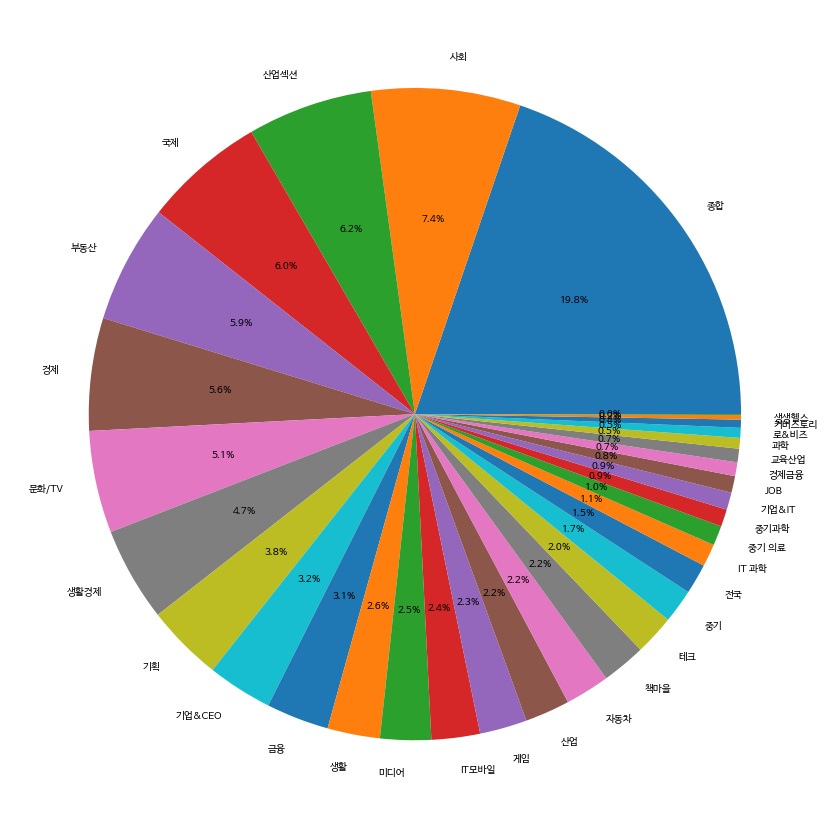

In [17]:
draw_pie(df)

count    12037.000000
mean         4.774113
std          3.738334
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         81.000000
Name: answers, dtype: float64


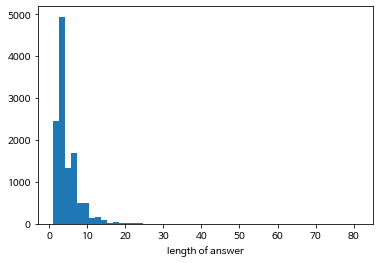

10.5


In [18]:
weight = df['answers'].map(lambda x: len(x['text'][0]))

print(weight.describe())

plt.hist(weight, bins=len(set(weight)), histtype='bar')
plt.xlabel('length of answer')
plt.show()

q3 = weight.quantile(0.75)
q1 = weight.quantile(0.25)
iqr = q3 - q1

print(q3 + 1.5 * iqr)

### AI-Hub 뉴스 기사 기계독해 데이터

- [뉴스 기사 기계독해 데이터](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=577)

In [19]:
def read_news(path):
    path = Path(path)
    with open(path, 'rb') as f:
        data = json.load(f)

    news_categories = []
    guids = []
    contexts = []
    questions = []
    answers = []
    for group in data['data']:
        news_category = group['doc_class']['code']
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                news_categories.append(news_category)
                guids.append(qa["question_id"])
                contexts.append(context)
                questions.append(qa['question'])
                answers.append({"answer_start": [qa['answers']['answer_start']], "text": [qa['answers']['text']]})
                
    return news_categories, guids, contexts, questions, answers

In [20]:
file_path = 'input/TL_span_extraction.json'

news_categories, guids, contexts, questions, answers = read_news(file_path)

news_df = pd.DataFrame(
    list(zip(news_categories, guids , answers, contexts, questions)),
    columns =['news_categories', 'id', 'answers', 'context', 'question'])
news_df

,news_categories,id,answers,context,question
0,스포츠,4559297,"{'answer_start': [4], 'text': ['서부권역 다목적 체육관']}",익산시 서부권역 다목적 체육관이 내달 개관을 앞두고 막바지 개관 준비가 한창이다. ...,익산시에서 시민들의 건강을 위해 운영을 준비 중인 시설은 뭐야
1,스포츠,4690367,"{'answer_start': [4], 'text': ['서부권역 다목적 체육관']}",익산시 서부권역 다목적 체육관이 내달 개관을 앞두고 막바지 개관 준비가 한창이다. ...,거주민들의 건강을 위하여 익산지역은 어떤 걸 만들고 있어
2,지역,4559299,"{'answer_start': [104], 'text': ['총 5회']}",무주군건강가정ㆍ다문화가족지원센터(센터장 장진원)가 아버지와 자녀를 대상으로 ‘아빠하...,무주군에서 진행되는 부자 부녀 대상 행사 횟수는 전부 몇 번이나 돼
3,지역,4690369,"{'answer_start': [104], 'text': ['총 5회']}",무주군건강가정ㆍ다문화가족지원센터(센터장 장진원)가 아버지와 자녀를 대상으로 ‘아빠하...,전체 몇 번의 부자 부녀 대상 활동을 무주군이 실시해
4,문화,4559300,"{'answer_start': [713], 'text': ['악동뮤지션']}",양희은의 노래 <엄마가 딸에게>는 엄마와 딸이 차마 말하지 못하는 속마음을 서로에게...,가수 양희은의 콜라보 프로젝트 중 여덟 번째 곡 나무는 어떤 후배와 불렀지
...,...,...,...,...,...
223931,기타,4961427,"{'answer_start': [68], 'text': ['여수시']}",권오봉 여수시장이 지난 6일 자산공원 현충탑에서 개최된 제66회 현충일 추념식에서 ...,어느 지역에서 현충탑을 새롭게 만들기로 했어
223932,기타,4830355,"{'answer_start': [580], 'text': ['하철경']}",임농 하철경 화백(61)은 한국화를 현대적 점묘화법 형태로 선보이는 작업으로 알려져...,전통수묵화의 거장으로 진도에 미술품을 기증한 사람은 누구야
223933,기타,4961425,"{'answer_start': [580], 'text': ['하철경']}",임농 하철경 화백(61)은 한국화를 현대적 점묘화법 형태로 선보이는 작업으로 알려져...,전통수묵화의 거장으로 진도에 미술품을 누가 기증했어
223934,기타,4830354,"{'answer_start': [202], 'text': ['6명']}",광주대학교(총장 김혁종)는 지난 9일 학교 행정관 회의실에서 장기근속자 공로패 수여...,광주대학교로부터 공로패를 전달받게 된 교원은 몇 명이야


In [21]:
news_df.loc[news_df.duplicated(['id']), :]

,news_categories,id,answers,context,question


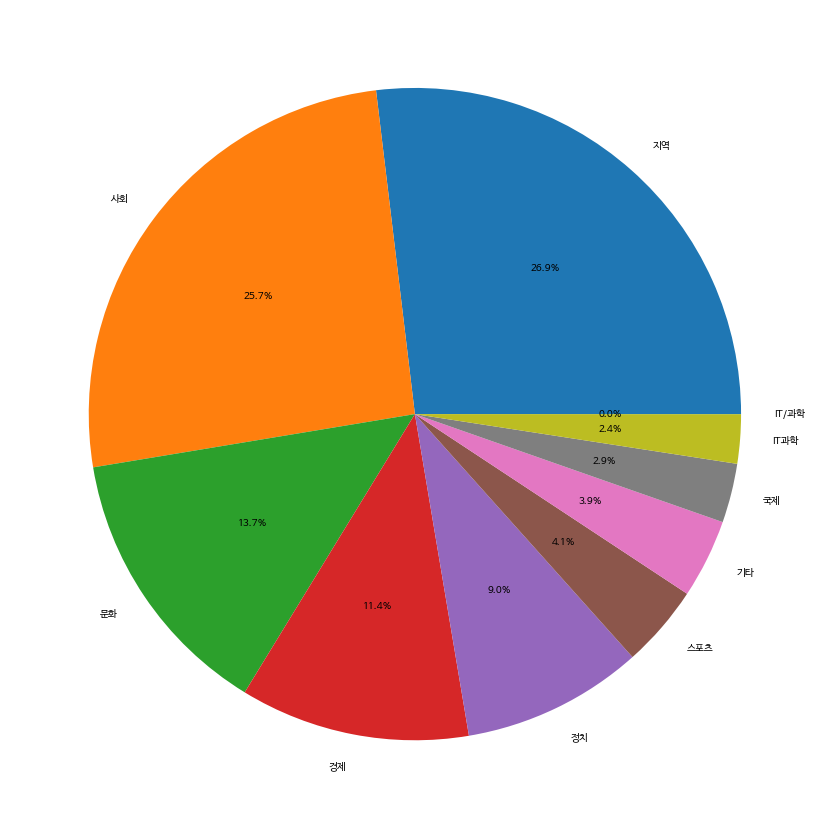

In [22]:
draw_pie(news_df)

In [23]:
my_list = ['스포츠', '정치', '지역']
news_df = news_df[~news_df['news_categories'].isin(my_list)]
print(news_df.shape)

(134432, 5)


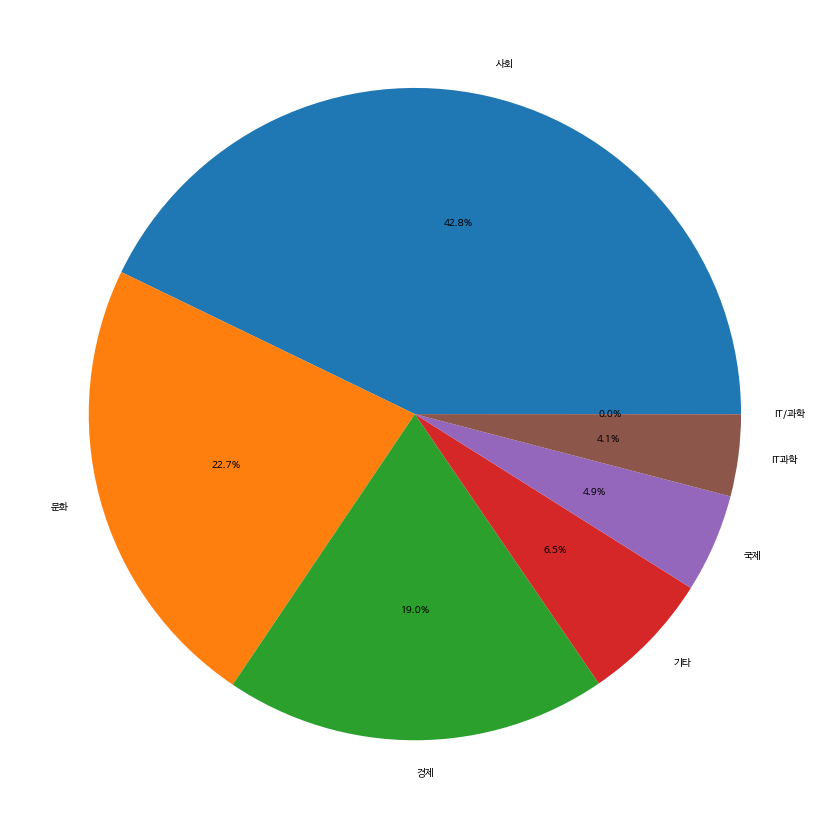

In [24]:
draw_pie(news_df)

In [25]:
news_df = news_df.sample(frac=0.6, random_state=args.seed)
print(news_df.shape)

(80659, 5)


### Concat

In [26]:
train_df = df.sample(frac=0.8, random_state=args.seed)
dev_df = df.drop(train_df.index)
print(f'{df.shape[0]} =====> train: {train_df.shape[0]} + dev: {dev_df.shape[0]}')

12037 =====> train: 9630 + dev: 2407


In [27]:
before = train_df.shape[0]
train_df = pd.concat([train_df, news_df])
train_df['id'] = train_df['id'].astype(str)
print(f'train: {train_df.shape[0]} <===== {before} + {news_df.shape[0]}')

train: 90289 <===== 9630 + 80659


In [28]:
train_df = train_df.drop(['news_categories'], axis=1)
dev_df = dev_df.drop(['news_categories'], axis=1)
print(train_df.shape)
print(dev_df.shape)

(90289, 4)
(2407, 4)


In [29]:
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)

In [30]:
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
print(train_dataset[0])
print(dev_dataset[0])

Number of Train Samples: 90289
Number of Dev Samples: 2407
{'id': '71a97d4e2e6041c3b6f4822e262af3a5', 'answers': {'answer_start': [1241], 'text': ['예약 번호']}, 'context': '세부퍼시픽은 신종 코로나바이러스 감염증(코로나19)로 인한 항공 여행에 대한 불안감을 해소하고 승객의 여행 편의를 높이기 위해 2020년 12월 31일까지 여행하는 승객 대상 유연한 여행 정책을 연장 적용한다고 발표했다. 세부퍼시픽 마케팅 및 고객 경험 담당 부사장인 캔디스 이요그(Candice Iyog)는 “세부퍼시픽은 코로나19로 인해 전 세계적으로 불확실성이 가중되는 상황에서 여행에 대한 우려를 완화시키기 위해 승객들의 목소리를 경청하며 정책을 보완하고 개선해 나가고 있습니다. 이에 따라 연장된 유연한 여행 정책이 승객들의 여행 계획에 조금이나마 도움이 되기를 바랍니다”라고 전했다. 금 번 연장된 여행 정책은 아래와 같이 적용된다. - 2년 유효기간의 트래블 펀드 트래블 펀드란 기존 항공권 예약을 위해 지불했던 총 금액을 현금으로 환불 받지 않고 온라인 상에 저장해 둘 수 있는 가상 지갑으로 항공편이 취소되었거나 여행 계획을 취소하려는 승객이 취할 수 있는 옵션이다. 2년 유효기간을 갖는 트래블 펀드는 최대 12개월 이내 항공편 예약시 트래블 펀드를 사용할 수 있으며 이를 통해 최대 2023년까지의 항공편에 트래블 펀드 사용이 가능하다. 유효기간 동안 승객들은 트래블 펀드를 이용하여 추후 새로운 항공권을 예약하거나 추가수하물, 옆좌석 구매 등 부가 서비스를 이용할 때 사용할 수 있다. 현재 여행 날짜가 미정인 승객들이 원하는 때 사용이 가능한 편리한 옵션으로 트래블 펀드 금액을 이미 소지하고 있는 고객의 경우 2년의 유효기간이 소급 적용되거나 트래블 펀드가 생성된 날로부터 2년이 적용된다. - 무제한 예약 변경 가능 세부퍼시픽의 승객은 재예약 또는 변경수수

In [31]:
del df, news_df
import gc
gc.collect()

5673

## Preprocessing the dataset

In [32]:
pad_on_right = tokenizer.padding_side == "right"

In [33]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=args.max_length,
        stride=args.doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [34]:
train_tokenized_dataset = train_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)
dev_tokenized_dataset = dev_dataset.map(prepare_train_features, batched=True, remove_columns=dev_dataset.column_names)

  0%|          | 0/91 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

# 2️⃣ Training & Fine-tuning the model

In [35]:
training_args = TrainingArguments(
    f"{args.name}-finetuned-klue",
    evaluation_strategy="epoch",
    save_strategy='epoch',
    logging_strategy='epoch',
    learning_rate=args.lr,
    per_device_train_batch_size=args.batch_size.train // args.accumulation,
    per_device_eval_batch_size=args.batch_size.dev // args.accumulation,
    num_train_epochs=args.epochs,
    gradient_accumulation_steps=args.accumulation, # Number of updates steps to accumulate the gradients for, before performing a backward/update pass.
    fp16=True, # Whether to use fp16 16-bit (mixed) precision training instead of 32-bit training.
    weight_decay=0.01,
    report_to = 'wandb',
    load_best_model_at_end = True,
    seed=args.seed
)

In [36]:
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=32,
gradient_checkpointing=False,
greater_is_better=False,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_

In [37]:
data_collator = default_data_collator

In [38]:
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=0.01)
scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=2000, num_training_steps=60000)
optimizers = optimizer, scheduler

In [39]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=dev_tokenized_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    optimizers=optimizers,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)] # https://huggingface.co/docs/transformers/main_classes/callback#transformers.EarlyStoppingCallback
)

Using cuda_amp half precision backend


In [40]:
trainer.train()

***** Running training *****
  Num examples = 90729
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 512
  Gradient Accumulation steps = 32
  Total optimization steps = 5310
  Number of trainable parameters = 117888770
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
0,6.587000,5.772328
1,4.002500,2.903503
2,1.646700,1.691074


***** Running Evaluation *****
  Num examples = 2442
  Batch size = 16
Saving model checkpoint to kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-177
Configuration saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-177/config.json
Model weights saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-177/pytorch_model.bin
tokenizer config file saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-177/tokenizer_config.json
Special tokens file saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-177/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2442
  Batch size = 16
Saving model checkpoint to kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-354
Configuration saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-354/config.json
Model weights saved in kobigbird-bert-base_lr1e-05_ep30_max102

Epoch,Training Loss,Validation Loss
0,6.587000,5.772328
1,4.002500,2.903503
2,1.646700,1.691074
3,1.105100,1.388731
4,0.917000,1.232406
5,0.806900,1.123801
6,0.721200,1.078335
7,0.650500,1.027110
8,0.590100,1.017393
9,0.529800,1.024204


***** Running Evaluation *****
  Num examples = 2442
  Batch size = 16
Saving model checkpoint to kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-708
Configuration saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-708/config.json
Model weights saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-708/pytorch_model.bin
tokenizer config file saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-708/tokenizer_config.json
Special tokens file saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-708/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2442
  Batch size = 16
Saving model checkpoint to kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-885
Configuration saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-885/config.json
Model weights saved in kobigbird-bert-base_lr1e-05_ep30_max102

TrainOutput(global_step=2478, training_loss=1.3662782719868436, metrics={'train_runtime': 56394.7939, 'train_samples_per_second': 48.265, 'train_steps_per_second': 0.094, 'total_flos': 7.0066795075729e+17, 'train_loss': 1.3662782719868436, 'epoch': 14.0})

In [41]:
trainer.save_model(f"{args.name}-finetuned-klue")

Saving model checkpoint to kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue
Configuration saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/config.json
Model weights saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/pytorch_model.bin
tokenizer config file saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/tokenizer_config.json
Special tokens file saved in kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/special_tokens_map.json


In [42]:
def plot_dict(dict_arrays, start_step=0, step_size=1, use_title=None, points_values=False, points_round=3,
              use_xlabel=None, use_xticks=True, use_rotation_xticks=0, xticks_labels=None, use_ylabel=None,
              style_sheet='ggplot', use_grid=True, use_linestyles=None, font_size=None, width=3, height=1, magnify=1.2,
              use_dpi=50, path=None, show_plot=True):
    # Check if `dict_arrays` is the correct format.
    if not isinstance(dict_arrays, dict):
        # Raise value error.
        raise ValueError("`dict_arrays` needs to be a dictionary of values!")

    # Check each label
    for label, array in dict_arrays.items():
        # Check if format is correct.
        if not isinstance(label, str):
            # Raise value error.
            raise ValueError("`dict_arrays` needs string keys!")
        if not isinstance(array, list) or isinstance(array, np.ndarray):
            # Raise value error.
            raise ValueError("`dict_arrays` needs lists values!")

    # Make sure style sheet is correct.
    if style_sheet in plt.style.available:
        # Set style of plot
        plt.style.use(style_sheet)
    else:
        # Style is not correct.
        raise ValueError("`style_sheet=%s` is not in the supported styles: %s" % (str(style_sheet),
                                                                                  str(plt.style.available)))

    # all linestyles.
    linestyles = ['-', '--', '-.', ':']

    # Make sure `font_size` is set right.
    if (font_size is not None) and (font_size <= 0):
        # Raise value error -  is not correct.
        raise ValueError(f'`font_size` needs to be positive number! Invalid value {font_size}')

    # Font variables dictionary. Keep it in this format for future updates.
    font_dict = dict(
        family='DejaVu Sans',
        color='black',
        weight='normal',
        size=font_size,
    )

    # Single plot figure.
    plt.subplot(1, 2, 1)

    # Use maximum length of steps. In case each arrya has different lengths.
    max_steps = []

    # Plot each array.
    for index, (use_label, array) in enumerate(dict_arrays.items()):
        # Set steps plotted on x-axis - we can use step if 1 unit has different value.
        if start_step > 0:
            # Offset all steps by start_step.
            steps = np.array(range(0, len(array))) * step_size + start_step
            max_steps = steps if len(max_steps) < len(steps) else max_steps
        else:
            steps = np.array(range(1, len(array) + 1)) * step_size
            max_steps = steps if len(max_steps) < len(steps) else max_steps

        # Plot array as a single line.
        plt.plot(steps, array, label=use_label)

    # Set horizontal axis name.
    plt.xlabel(use_xlabel, fontdict=font_dict)

    # Use x ticks with steps or labels.
    plt.xticks(max_steps, xticks_labels, rotation=use_rotation_xticks) if use_xticks else None

    # Set vertical axis name.
    plt.ylabel(use_ylabel, fontdict=font_dict)

    # Adjust both axis labels font size at same time.
    plt.tick_params(labelsize=font_dict['size'])

    # Place legend best position.
    plt.legend(loc='best', fontsize=font_dict['size'])

    # Set title of figure.
    plt.title(use_title, fontdict=font_dict)

    # Display grid depending on `use_grid`.
    plt.grid(use_grid)

    # Make figure nice.
    plt.tight_layout()

    # Get figure object from plot.
    fig = plt.gcf()

    # Get size of figure.
    figsize = fig.get_size_inches()

    # Change size depending on height and width variables.
    figsize = [figsize[0] * width * magnify, figsize[1] * height * magnify]

    # Set the new figure size with magnify.
    fig.set_size_inches(figsize)

    # Show plot.
    plt.show() if show_plot is True else None

    return

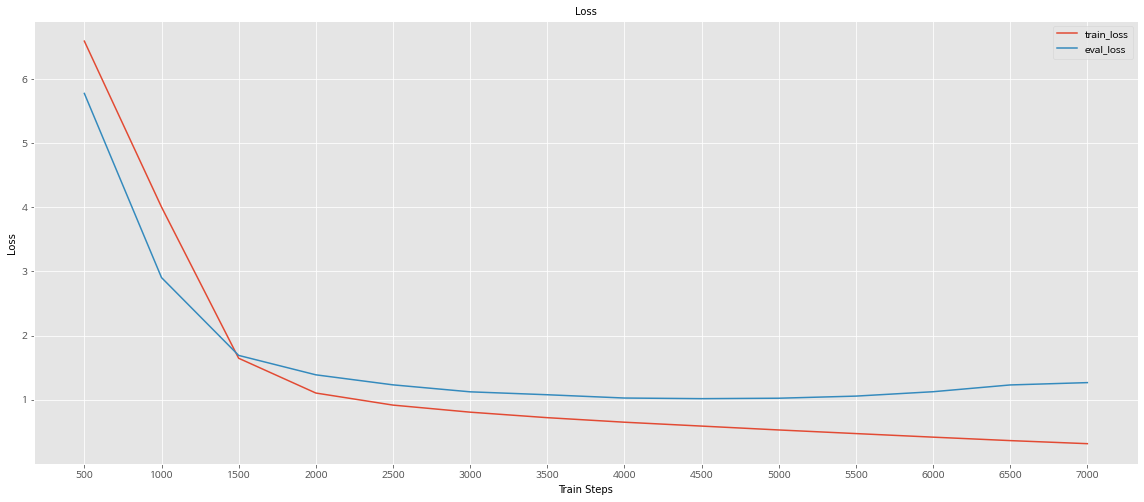

"# Plot Perplexities.\nplot_dict(perplexity_history, start_step=training_args.logging_steps, \n          step_size=training_args.logging_steps, use_title='Perplexity', \n          use_xlabel='Train Steps', use_ylabel='Perplexity', magnify=2)"

In [43]:
# Keep track of train and evaluate loss.
loss_history = {'train_loss':[], 'eval_loss':[]}
 
# Keep track of train and evaluate perplexity.
# This is a metric useful to track for language models.
perplexity_history = {'train_perplexity':[], 'eval_perplexity':[]}
 
# Loop through each log history.
for log_history in trainer.state.log_history:
 
  if 'loss' in log_history.keys():
    # Deal with trianing loss.
    loss_history['train_loss'].append(log_history['loss'])
    #perplexity_history['train_perplexity'].append(math.exp(log_history['loss']))
     
  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])
    #perplexity_history['eval_perplexity'].append(math.exp(log_history['eval_loss']))
 
# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Loss', magnify=2)
 
print()
 
'''# Plot Perplexities.
plot_dict(perplexity_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Perplexity', 
          use_xlabel='Train Steps', use_ylabel='Perplexity', magnify=2)'''

# 3️⃣ Evaluation

In [44]:
pad_on_right = tokenizer.padding_side == "right"

In [45]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=args.max_length,
        stride=args.doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [46]:
validation_features = dev_dataset.map(
    prepare_validation_features,
    batched=True,
    remove_columns=dev_dataset.column_names
)

  0%|          | 0/3 [00:00<?, ?ba/s]

In [47]:
raw_predictions = trainer.predict(validation_features)

The following columns in the test set don't have a corresponding argument in `BigBirdForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping. If example_id, offset_mapping are not expected by `BigBirdForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2442
  Batch size = 16


In [ ]:
with open(f'output/raw_predictions-{args.name}-finetuned-klue.pkl', 'wb') as fd:
    pickle.dump(raw_predictions, fd)

## Postprocessing

In [72]:
def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

In [73]:
squad_v2 = False

print(args.n_best_size)
print(args.max_answer_length)

10
10


In [ ]:
final_predictions = postprocess_qa_predictions(dev_dataset, validation_features, raw_predictions.predictions, n_best_size = args.n_best_size, max_answer_length = args.max_answer_length)

## Evaluation

In [ ]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

In [ ]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in dev_dataset]
metric.compute(predictions=formatted_predictions, references=references)

In [71]:
predictions_text = pd.DataFrame.from_dict(formatted_predictions)['prediction_text']
references_text = pd.DataFrame.from_dict(references)['answers'].map(lambda x: x['text'][0])
distances = []

for i, k in zip(predictions_text, references_text):
    distances.append(distance(i, k))

print(np.mean(distances))

1.5882841711674283


## Error analysis

In [55]:
dev_df['predictions_text'] = list(predictions_text)
dev_df['distance'] = distances

In [74]:
distance_threshold = 10

mask = dev_df.distance >= distance_threshold
dev_df_error = dev_df.loc[mask, :]

dev_df_error

,id,answers,context,question,predictions_text,distance
5,8d0e83b1227748fe94aabf5600f62f3b,"{'answer_start': [661], 'text': ['환경오염이 심한 지역']}",“앞으로 5년 안에 아시아 친환경·신재생에너지 투자의 황금기가 도래할 것입니다.”기...,정부에게 환경과 관련해서 우선적으로 원조 받고 있는 곳은?,중국,11
13,00a98de27a63414d9af4713431daa51c,"{'answer_start': [119], 'text': ['TV']}",삼성전자가 경영난을 겪고 있는 일본 샤프에 출자해 지분 3%를 확보한다. 일본에서 ...,삼성전자가 이번 투자로 샤프에서 공급받으려는 부품은 어떤 가전제품의 것인가?,60인치 이상 대형 LCD TV,15
666,a19dca75831448248f2c25e091551aa4,"{'answer_start': [899], 'text': ['Monster Movi...",캔의 뿌리는 이르민 슈미트 의 1966년 뉴욕 여행에서 시작되었다. 슈미트는 스티브...,Yoo Doo Right이 수록된 앨범명은?,Delay 1968,12
707,ba37e78d712d41bf946a1ed6f162a4ad,"{'answer_start': [775], 'text': ['일본']}",“일본 철강업체들의 텃밭인 태국에서 가동 3년 만에 흑자를 일궈냈습니다.”지난 17...,태국인들은 어느 나라의 자동차를 가장 많이 타는가?,"도요타와 혼다, 닛산 등 일본",14
717,de4a35439ea14b89b1e548892e16e483,"{'answer_start': [124], 'text': ['진료과장']}",대림성모병원(병원장 김성원)은 오는 29일 오후 3시부터 본관 12층 회의실에서 ‘...,척추압박골절 건강강좌에서 강연을 하는 사람의 직책은?,척추신경외과 이승준 진료과장이,12
...,...,...,...,...,...,...
11837,de4562062fcd492bbb40d71f40cf31ec,"{'answer_start': [453], 'text': ['일개미들이 가져온 잎']}",같은 가위개미인 에크로머멕스속과 닮은 점이 매우 많고 유전적으로도 유사하다. 보통의...,아타속이 먹는 균이 길러지는 곳은?,잎,10
11890,875e86bcb89a48d595f9326c42f7dbbd,"{'answer_start': [754], 'text': ['카이스트 AI 대학원']}",인공지능 기업 슈퍼브에이아이가 한국정보통신기술협회(TTA)의 데이터 검사 사업자로 ...,2020 NeurIPS에서 뽑힌 논문을 작성한 곳은?,슈퍼브에이아이,11
11973,82ce283b320a4685a21a8fc9daec88b0,"{'answer_start': [757], 'text': ['500']}","유닛8200은 의무복무(남자 3년, 여자 2년)를 해야 하는 이스라엘 젊은이들이 가...",작년에 맥시밈에 참여하도록 뽑힌 인원 수는?,1400여명이 지원해 500,12
12012,844ecad528494dc3876bab263abde6d2,"{'answer_start': [582], 'text': ['맥주']}","패스트파이브(공동대표 박지웅, 김대일)가 설립 2주년을 맞아 그 동안 성장 과정이 ...",패스트파이브에서 회원들이 공짜로 마실 수 있는 술은?,로스팅 커피와 수제 맥주,11


In [ ]:
dev_df_error.to_csv(f"output/error_case-{args.name}.csv", index=False)

# 4️⃣ Submission

In [ ]:
def read_test(path):
    path = Path(path)
    with open(path, 'rb') as f:
        data = json.load(f)

    ids = []
    contexts = []
    questions = []
    answers = []
    for group in data['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                id = qa["guid"]
                question = qa['question']
                answer = qa['answers']
                contexts.append(context)
                questions.append(question)
                answers.append(answer)
                ids.append(id)

    return ids, contexts, questions, answers

In [ ]:
file_path =  'input/test.json'

ids, contexts, questions, answers = read_test(file_path)

test_df = pd.DataFrame(
    list(zip(ids , answers, contexts, questions)),
    columns =['id','answers', 'context','question'])
test_df

In [60]:
test_dataset = Dataset.from_pandas(test_df)
print("Number of Test Samples:", len(test_dataset))

Number of Test Samples: 4008


In [61]:
test_features = test_dataset.map(
    prepare_validation_features,
    batched=True,
    remove_columns=test_dataset.column_names
)

  0%|          | 0/5 [00:00<?, ?ba/s]

In [62]:
test_raw_predictions = trainer.predict(test_features)

The following columns in the test set don't have a corresponding argument in `BigBirdForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping. If example_id, offset_mapping are not expected by `BigBirdForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4073
  Batch size = 16


In [ ]:
with open(f'output/test_raw_predictions-{args.name}-finetuned-klue.pkl', 'wb') as fd:
    pickle.dump(test_raw_predictions, fd)

In [ ]:
test_final_predictions = postprocess_qa_predictions(test_dataset, test_features, test_raw_predictions.predictions, n_best_size = args.n_best_size, max_answer_length = args.max_answer_length)

In [ ]:
test_formatted_predictions = [{"Id": k, "Predicted": v} for k, v in test_final_predictions.items()]

In [75]:
pd.DataFrame.from_dict(test_formatted_predictions)

,Id,Predicted
0,d14cb73158624cf094c546d856fd3c80,뉴 740Li
1,906631384e91493ebe1c7f34aea6f241,독일 뒤셀도르프로
2,35e61dcb479643448a2cb7d326ae50a6,링크트인과 페이스북
3,075e761b370040cb9041eecd39afc27c,링크트인과 페이스북
4,e67ed38f3dd944be94d5b4c53731f334,마드리드
...,...,...
4003,05fcb8054dc44dab8683579c2cf5e465,400만엔에서 200만엔
4004,cc7f826b66724ce9b39e3a974ca15661,중동
4005,3282034aa41e4fab980851ffd4a868dd,아시아~유럽
4006,0a73550b36df4baf82ac2f98619d22e7,10일


In [ ]:
df = pd.DataFrame.from_dict(test_formatted_predictions)

os.makedirs('output', exist_ok=True)
df.to_csv(f'output/submission-{args.name}.csv', index = False, header=True)

In [ ]:
pd.read_csv('input/baseline.csv')

In [69]:
pd.read_csv(f'output/submission-{args.name}.csv')

,Id,Predicted
0,d14cb73158624cf094c546d856fd3c80,뉴 740Li
1,906631384e91493ebe1c7f34aea6f241,독일 뒤셀도르프로
2,35e61dcb479643448a2cb7d326ae50a6,링크트인과 페이스북
3,075e761b370040cb9041eecd39afc27c,링크트인과 페이스북
4,e67ed38f3dd944be94d5b4c53731f334,마드리드
...,...,...
4003,05fcb8054dc44dab8683579c2cf5e465,400만엔에서 200만엔
4004,cc7f826b66724ce9b39e3a974ca15661,중동
4005,3282034aa41e4fab980851ffd4a868dd,아시아~유럽
4006,0a73550b36df4baf82ac2f98619d22e7,10일


In [70]:
args.name

'kobigbird-bert-base_lr1e-05_ep30_max1024_317'

# References

- https://github.com/huggingface/notebooks/blob/main/examples/question_answering.ipynb
- https://github.com/gmihaila/ml_things/blob/master/src/ml_things/plot_functions.py
- https://www.topbots.com/pretrain-transformers-models-in-pytorch/